# 인코딩(encoding)과 디코딩(decoding)

- 인코딩-디코딩 아키텍쳐는 통신, 암호, 전자 등 다양한 분야에 적용되는 일반적인 프레임워크

- 인코더는 입력 샘플을 잠재 공간, 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수

- 디코더는 이 잠재 공간의 요소를 사전 정의된 타겟 도메인으로 매핑하는 여함수

- 예를 들어, 이미지와 오디오 압축 포맷

  - JPEG 도구는 미디어 파일을 가벼운 이진파일로 압축하여 인코딩하고, 표시할 떄 픽셀 값을 복원하기 위해 디코딩

  <img src="https://image.slidesharecdn.com/aes171113-180510014736/95/-48-638.jpg?cb=1525916931">

  <sub>[이미지 출처] https://www.slideshare.net/NaverEngineering/ss-96581209</sub>

# 오토인코더(Autoencoder, AE)

- 입력을 저차원 잠재공간으로 인코딩한 후 디코딩하여 복원하는 네트워크  
  즉, 이미지를 입력받아 인코더 모듈을 사용하여 잠재 벡터 공간으로 매핑하고,  
  디코더 모듈을 사용하여 원본 이미지와 동일한 차원으로 복원하여 출력

- 원본 입력을 재구성하는 방법으로 학습

- 고전적인 방식은 구조화가 잘된 잠재 공간을 만들지 못하고,  
  압축도 뛰어나지 않음

  <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png">

  <sub>[이미지 출처] https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub>

## Fashon MNIST Dataset

- 코드 참조 : https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.losses import MeanSquaredError

### 데이터 로드

In [2]:
# 이미지이기 때문에 y데이터가 필요하지 않음
(X_train, _), (X_test, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# 정규화
X_train = X_train.astype(np.float32) / 255. # 32비트로 보내고 싶을 때
X_test = X_test.astype('float32') / 255. 
X_train.shape, X_test.shape, np.min(X_train), np.max(X_train)

((60000, 28, 28), (10000, 28, 28), 0.0, 1.0)

### 모델 정의

- 이미지를 64 차원 잠재 벡터로 압축하는 encoder 및 잠재 공간에서 원본 이미지를 재구성하는 decoder 라는 두 개의 Dense 레이어로 오토 encoder 정의

- Keras Model Subclassing API를 사용

In [4]:
LATENT_DIM = 64

class AutoEncoder(Model):
    def __init__(self, latent_dim=LATENT_DIM):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([Flatten(),
                                   Dense(latent_dim, activation='relu')])
        self.decoder = Sequential([Dense(784, activation='sigmoid'),
                                   Reshape((28,28))])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 모델 생성 및 컴파일

In [5]:
ae = AutoEncoder(LATENT_DIM)
ae.compile(optimizer='adam', loss=MeanSquaredError())

### 모델 학습
- x_train 을 입력과 목표 모두로 사용하여 모델을 훈련

- encoder 는 데이터 세트를 784 차원에서 잠재 공간으로 압축하는 방법을 배우고,  
  decoder 는 원본 이미지를 재구성하는 방법을 배움

In [6]:
ae.fit(X_train, X_train, epochs=30, validation_data=(X_test, X_test))

Epoch 1/30
1875/1875 [==============================] - 7s 2ms/step - loss: 0.0234 - val_loss: 0.0132
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

In [7]:
ae.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                50240     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


### 모델 테스트

In [8]:
encoded_imgs = ae.encoder(X_test).numpy()
decoded_imgs = ae.decoder(encoded_imgs).numpy() # 인코딩한 이미지를 넘파이로 받아라

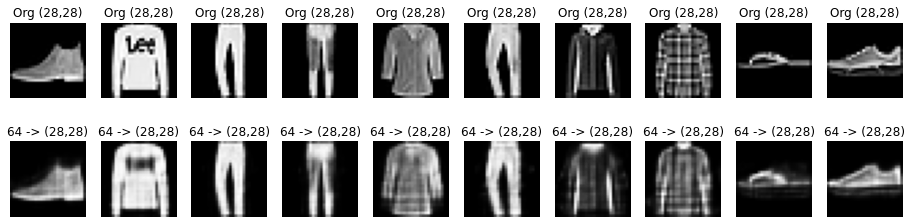

In [9]:
plt.figure(figsize=(16,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Org (28,28)')
    plt.axis('off')
# 오리지널 이미지

# 디코딩된 이미지
    plt.subplot(2,10,i+11)
    plt.imshow(decoded_imgs[i], cmap='gray')
    plt.title('64 -> (28,28)')
    plt.axis('off')  
plt.show()  

- Latent dim: 100, Epoch: 30

In [10]:
ae2 = AutoEncoder(100)
ae2.compile(optimizer='adam', loss=MeanSquaredError())

In [11]:
ae2.fit(X_train, X_train, epochs=30, validation_data=(X_test, X_test))

Epoch 1/30
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0210 - val_loss: 0.0112
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.006

In [12]:
encoded_imgs2 = ae2.encoder(X_test).numpy()
decoded_imgs2 = ae2.decoder(encoded_imgs2).numpy()

- Latent dim: 40, Epoch: 30

In [13]:
ae3 = AutoEncoder(40)
ae3.compile(optimizer='adam', loss=MeanSquaredError())
ae3.fit(X_train, X_train, epochs=30, validation_data=(X_test, X_test), verbose=0)

In [14]:
encoded_imgs3 = ae3.encoder(X_test).numpy()
decoded_imgs3 = ae3.decoder(encoded_imgs3).numpy()

- Latent dim: 64, Epoch:100

In [15]:
ae4 = AutoEncoder(64)
ae4.compile(optimizer='adam', loss=MeanSquaredError())
ae4.fit(X_train, X_train, epochs=100, validation_data=(X_test, X_test), verbose=0)

In [16]:
encoded_imgs4 = ae4.encoder(X_test).numpy()
decoded_imgs4 = ae4.decoder(encoded_imgs4).numpy()

- 종합 비교

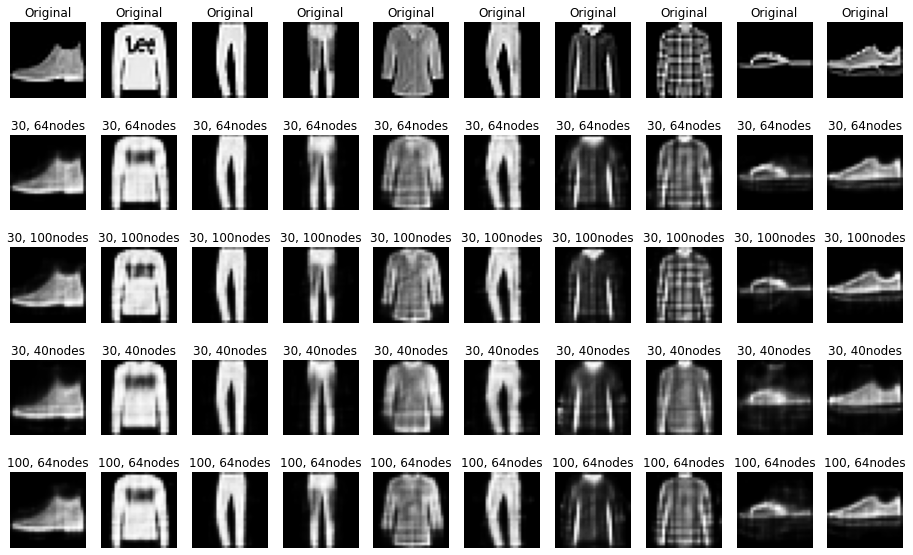

In [17]:
imgs = [X_test, decoded_imgs, decoded_imgs2, decoded_imgs3, decoded_imgs4]
titles = ['Original','30, 64nodes','30, 100nodes','30, 40nodes','100, 64nodes']
plt.figure(figsize=(16,10))
for i, img in enumerate(imgs):
    for k in range(10):
        plt.subplot(5, 10, i*10 + k + 1)
        plt.imshow(img[k], cmap='gray')
        plt.title(titles[i]), plt.axis('off')
plt.show()